In [1]:
from cv2 import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import dblquad
from math import pi, exp

In [2]:
#Settings

IMAGE_NAME = "your_test_image4.jpg" #Please change this to the name of your test image
IMAGE_SCALE_FACTOR = 1./2
SIGMA_0 = 1.6
SIGMA_SCALE_FACTOR = 2**0.5
SIGMA_MAX = 4*SIGMA_0
KERNEL_SIZE = 15

ORIG_IMAGE = imread(IMAGE_NAME, 0)
ORIG_HEIGHT, ORIG_WIDTH = ORIG_IMAGE.shape

In [3]:
def convolve(image, kernel):
    height, width = image.shape
    conv_img = np.zeros((height + 1 - len(kernel) , width + 1 - len(kernel[0])), dtype='int32')
    for i in range(0, len(conv_img)):
        for j in range(0, len(conv_img[0])):
            conv_img[i,j] = np.sum(np.multiply(image[i:i+len(kernel), j:j+len(kernel[0])], kernel))
    return np.absolute(conv_img)

def gaussian_kernel(sigma):
    def function(x, y):
        return (1/(2*pi*(sigma**2)))*exp(-(x**2 + y**2)/(2*(sigma**2)))
    xmin = -3*SIGMA_MAX
    xmax = 3*SIGMA_MAX
    step = float(xmax - xmin)/KERNEL_SIZE
    limits = np.arange(xmin, xmax, step)
    kernel_temp = [[dblquad(function, x, x + step, lambda c: y, lambda c:y + step) for x in limits] for y in limits]
    kernel = [map(lambda (x, y): x, seq) for seq in kernel_temp]
    return kernel


In [4]:
def get_image_with_extrema():
    points = []
    for i in range(3):
        current_image_scale_factor = IMAGE_SCALE_FACTOR**i
        current_img = resize(ORIG_IMAGE, (int(ORIG_WIDTH * current_image_scale_factor), int(ORIG_HEIGHT * current_image_scale_factor)))
        points.extend(get_points_for_image(current_img, current_image_scale_factor))
    points = set(points)
    display = plt.imshow(ORIG_IMAGE, cmap='Greys_r')
    plt.scatter(x=map(lambda (x,y) : y, points), y=map(lambda (x,y) : x, points), c='r', marker='x')
    plt.savefig(IMAGE_NAME[:len(IMAGE_NAME) - 4] + '_with_extrema.png', bbox_inches='tight', pad_inches=0)
    plt.show()
    
def get_points_for_image(image, scale_factor):
    global i_comm
    blurred_images = [convolve(image, gaussian_kernel(SIGMA_SCALE_FACTOR**i * SIGMA_0)) for i in range(5)]
    dog_images = [np.subtract(blurred_images[i], blurred_images[i+1]) for i in range(4)]
    points = []
    for i in [1,2]:
        points.extend(get_extrema(dog_images[i], dog_images[i-1], dog_images[i+1]))
    return map(lambda (x,y) : (int(x/scale_factor), int(y/scale_factor)), points)

def get_extrema(current_layer, above, below):
    height, width = current_layer.shape
    points = []
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            if is_extrema(current_layer[i-1:i+2, j-1:j+2], above[i-1:i+2, j-1:j+2], below[i-1:i+2, j-1:j+2]):
                points.append((i + KERNEL_SIZE/2, j + KERNEL_SIZE/2))
    return points

def is_extrema(current, above, below):
    point = current[1][1]
    height, width = above.shape
    is_min = True
    is_max = True
    for i in range(height):
        for j in range(width):
            if not (is_min or is_max):
                return False
            if is_max and (point <= above[i, j] or point <= below[i,j]):
                is_max = False
            if is_min and (point >= above[i, j] or point >= below[i,j]):
                is_min = False
            if not (i == 1 and j == 1):
                if is_max and point <= current[i, j]:
                    is_max = False
                if is_min and point >= current[i, j]:
                    is_min = False
    if is_min or is_max:
        return True
    else:
        return False

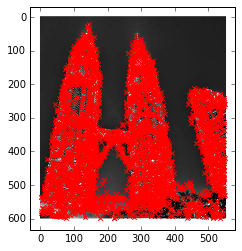

In [5]:
#NOTE 1: The image will also be saved in the directory you run this from

#NOTE 2: It may take some time to run. It does not print any output in the meantime. Please do not exit

get_image_with_extrema()